In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import geopandas as gpd
from shapely.geometry import Point
from geopandas import GeoSeries, GeoDataFrame
import json

## Problem 
Can the descriptor of a park complaint and the historical crime data of the parks be used to determine whether or not action needs to be taken by the Parks department

In [2]:
df = pd.read_csv('311parkcomplaints.csv')

In [3]:
nyc = gpd.read_file('nycd_17c/nycd.shp')

In [4]:
df.head()

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,...,Bridge Highway Name,Bridge Highway Direction,Road Ramp,Bridge Highway Segment,Garage Lot Name,Ferry Direction,Ferry Terminal Name,Latitude,Longitude,Location
0,35120774,12/28/2016 13:48,12/29/2016 13:02,DPR,Department of Parks and Recreation,Violation of Park Rules,Obstructing Public Use,Park,11211.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,35118466,12/28/2016 11:59,12/28/2016 12:28,DPR,Department of Parks and Recreation,Violation of Park Rules,Obstructing Public Use,Park,10459.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,35117255,12/28/2016 11:41,4/1/2017 13:54,DPR,Department of Parks and Recreation,Violation of Park Rules,Unlicensed Vendors,Park,10007.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,35112397,12/27/2016 13:06,4/1/2017 13:54,DPR,Department of Parks and Recreation,Violation of Park Rules,Unsafe Use of Playground,Park,10031.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,35108246,12/26/2016 12:43,12/26/2016 12:57,DPR,Department of Parks and Recreation,Violation of Park Rules,Obstructing Public Use,Park,11426.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df.Descriptor.unique()

array(['Obstructing Public Use', 'Unlicensed Vendors',
       'Unsafe Use of Playground', 'Unauthorized Posting of Signs',
       'Biking/Rollerblading off Path', 'Smoking',
       'BBQ Outside Authorized Area', 'Unauthorized Climbing',
       'Removing Flowers/Plants', 'Unauthorized Film Shoot',
       'Use of Newly Seeded Lawn'], dtype=object)

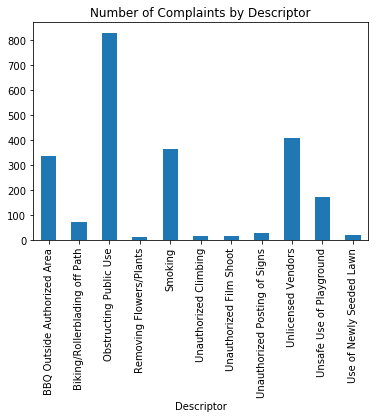

In [6]:
df.groupby('Descriptor').size().plot(kind='bar')
plt.title('Number of Complaints by Descriptor')

In [7]:
df['PARK'] = df['Park Facility Name'].apply(lambda x: x.upper())

In [8]:
df = df[['PARK', 'Created Date', 'Closed Date', 'Agency', 'Complaint Type', 'Descriptor',
        'Incident Zip', 'City', 'Status', 'Borough', 'Due Date', 'Resolution Description',
        'Borough', 'Y Coordinate (State Plane)', 'X Coordinate (State Plane)', 'Park Borough', 'Latitude', 'Longitude']]

In [9]:
geometry = [Point(xy) for xy in zip(df['Longitude'], df['Latitude'])]
gdf = GeoDataFrame(df, geometry=geometry)

In [10]:
gdf.crs = {'init' : 'epsg:4326'}

In [11]:
nyc.crs

{u'datum': u'NAD83',
 u'lat_0': 40.16666666666666,
 u'lat_1': 40.66666666666666,
 u'lat_2': 41.03333333333333,
 u'lon_0': -74,
 u'no_defs': True,
 u'proj': u'lcc',
 u'units': u'us-ft',
 u'x_0': 300000,
 u'y_0': 0}

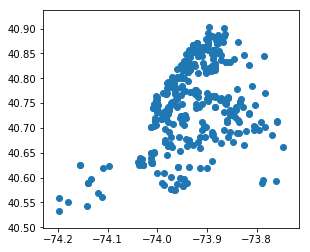

In [12]:
gdf.plot()
gdf = gdf.to_crs(nyc.crs)

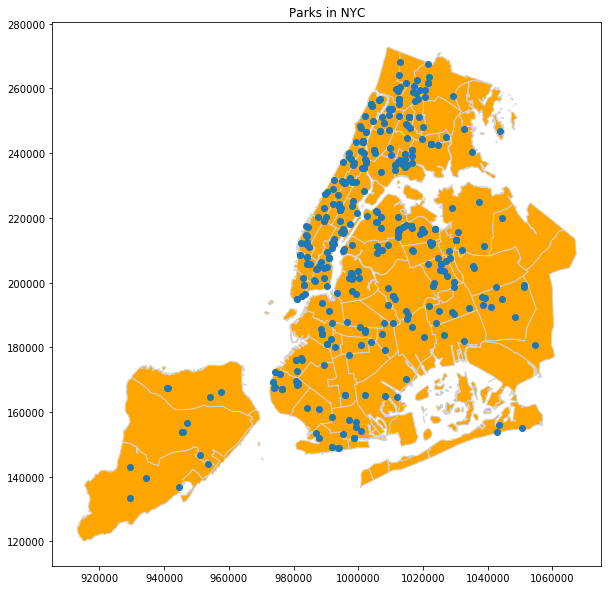

In [13]:
base = nyc.plot(color = 'orange', edgecolor='lightgray', linewidth=1, figsize=(10,10))
gdf.plot(ax=base)
plt.title('Parks in NYC')

In [14]:
resolutions = df['Resolution Description'].unique()
gres = [1,2,4,5,8,10,12,13]
res1 = []
for i in range(len(resolutions)):
    if i in (gres):
        res1.append(resolutions[i])
        

In [15]:
res1

['The condition was determined to be an issue appropriate for handling by an alternate entity.  The Department of Parks and Recreation has notified the appropriate resource.',
 'The Department of Parks and Recreation has completed the requested work order and corrected the problem.',
 'The reported condition was inspected and a summons has been issued.',
 'The issue has been inspected and the offending party has been confronted and informed of their wrongdoing.  The situation has been remedied.',
 'The condition was determined to be an emergency issue and NYPD was notified.',
 'Work to correct the reported condition is under review for a future capital project.',
 'The reported condition was inspected and an arrest was made.',
 'Work to correct the reported condition has been deferred because of seasonal considerations and will be corrected as soon as possible.']

In [16]:
def make_cat(response):
    if response in res1:
        return 1
    else:
        return 0

In [17]:
df['ActionNeeded'] = df['Resolution Description'].apply(make_cat)

In [18]:
df_descr = pd.get_dummies(df['Descriptor'])

In [19]:
df2 = pd.concat([df, df_descr], axis=1)

In [67]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [21]:
df2.columns

Index([u'PARK', u'Created Date', u'Closed Date', u'Agency', u'Complaint Type',
       u'Descriptor', u'Incident Zip', u'City', u'Status', u'Borough',
       u'Due Date', u'Resolution Description', u'Borough',
       u'Y Coordinate (State Plane)', u'X Coordinate (State Plane)',
       u'Park Borough', u'Latitude', u'Longitude', u'geometry',
       u'ActionNeeded', u'BBQ Outside Authorized Area',
       u'Biking/Rollerblading off Path', u'Obstructing Public Use',
       u'Removing Flowers/Plants', u'Smoking', u'Unauthorized Climbing',
       u'Unauthorized Film Shoot', u'Unauthorized Posting of Signs',
       u'Unlicensed Vendors', u'Unsafe Use of Playground',
       u'Use of Newly Seeded Lawn'],
      dtype='object')

In [22]:
y = df2['ActionNeeded']
features = ['Biking/Rollerblading off Path', 'Obstructing Public Use', 'Removing Flowers/Plants',
       'Smoking', 'Unauthorized Climbing', 'Unauthorized Film Shoot', 'Unauthorized Posting of Signs',
       'Unlicensed Vendors', 'Unsafe Use of Playground', 'Use of Newly Seeded Lawn']
x = df2[features]
model = LogisticRegression()
model = model.fit(x, y)
model.score(x, y)

0.64543057996485065

In [23]:
def get_data(frame, featureslist):
    y = frame.ActionNeeded.values
    X = frame[featureslist].values
    if len(X.shape) == 1:
        X = X.reshape(-1, 1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .33)
    return X_train, X_test, y_train, y_test

In [24]:
def cv_optimize(xtrain, ytrain, n_folds=10, num_p=100):
    clf = LogisticRegression()
    parameters = {"C": np.logspace(-4, 3, num=num_p)}
    gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds)
    gs.fit(xtrain, ytrain)
    return gs.best_params_, gs.best_score_

In [25]:
def fit_logistic(xtrain, ytrain, xtest, ytest, reg=0.0001):
    clf2 = LogisticRegression(C=reg)
    clf2.fit(xtrain, ytrain)
    probs = clf2.predict(xtest)
    return probs, clf2

In [26]:
def cv_and_fit(frame, featureslist, n_folds=5):
    xtrain, xtest, ytrain, ytest = get_data(frame, featureslist)
    bp, bs = cv_optimize(xtrain, ytrain, n_folds=n_folds)
    predict, clf = fit_logistic(xtrain, ytrain, xtest, ytest, reg=bp['C'])
    pred = metrics.accuracy_score(ytest, predict)
    return predict, clf, pred

In [27]:
res, clf, score = cv_and_fit(df2, features)

In [69]:
print("Model accuracy using descriptions of the park complaint: " + str(score))

Model accuracy using descriptions of the park complaint: 0.642287234043


In [29]:
crime_data = pd.read_excel('nyc_park_crime_stats_q4_2014.xlsx')


In [30]:
crime_data.head()

,PARK,BOROUGH,SIZE (ACRES),CATEGORY,Murder,RAPE,ROBBERY,FELONY ASSAULT,BURGLARY,GRAND LARCENY,GRAND LARCENY OF MOTOR VEHICLE,TOTAL
0,PELHAM BAY PARK,BRONX,2771.747,ONE ACRE OR LARGER,0,0,0,0,0,0,0,0
1,VAN CORTLANDT PARK,BRONX,1146.430,ONE ACRE OR LARGER,0,0,0,1,0,2,0,3
2,ROCKAWAY BEACH AND BOARDWALK,QUEENS,1072.564,ONE ACRE OR LARGER,0,0,0,0,0,0,0,0
3,FRESHKILLS PARK,STATEN ISLAND,913.320,ONE ACRE OR LARGER,0,0,0,0,0,0,0,0
4,FLUSHING MEADOWS CORONA PARK,QUEENS,897.690,ONE ACRE OR LARGER,0,0,0,2,2,8,0,12


In [31]:
crime_data = crime_data[['PARK', 'SIZE (ACRES)', 'TOTAL']]

In [32]:
result = pd.merge(df2, crime_data, how='left', on='PARK')

In [66]:
result.head()

,PARK,Created Date,Closed Date,Agency,Complaint Type,Descriptor,Incident Zip,City,Status,Borough,...,Removing Flowers/Plants,Smoking,Unauthorized Climbing,Unauthorized Film Shoot,Unauthorized Posting of Signs,Unlicensed Vendors,Unsafe Use of Playground,Use of Newly Seeded Lawn,SIZE (ACRES),TOTAL
0,MCCARREN PARK,12/28/2016 13:48,12/29/2016 13:02,DPR,Violation of Park Rules,Obstructing Public Use,11211.0,BROOKLYN,Closed,BROOKLYN,...,0,0,0,0,0,0,0,0,35.713,0.0
2,CITY HALL PARK,12/28/2016 11:41,4/1/2017 13:54,DPR,Violation of Park Rules,Unlicensed Vendors,10007.0,NEW YORK,Closed,MANHATTAN,...,0,0,0,0,0,1,0,0,8.800,0.0
3,ALEXANDER HAMILTON PLAYGROUND,12/27/2016 13:06,4/1/2017 13:54,DPR,Violation of Park Rules,Unsafe Use of Playground,10031.0,NEW YORK,Closed,MANHATTAN,...,0,0,0,0,0,0,1,0,0.811,0.0
4,ALLEY POND PARK,12/26/2016 12:43,12/26/2016 12:57,DPR,Violation of Park Rules,Obstructing Public Use,11426.0,BELLEROSE,Closed,QUEENS,...,0,0,0,0,0,0,0,0,635.514,0.0
5,FERRY POINT PARK,12/26/2016 10:23,12/26/2016 10:57,DPR,Violation of Park Rules,Obstructing Public Use,10465.0,BRONX,Closed,BRONX,...,0,0,0,0,0,0,0,0,413.800,0.0


In [33]:
features.append('TOTAL')

In [44]:
print(result['TOTAL'].min(),result.TOTAL.max())

(0.0, 17.0)


In [42]:
x = result[features]
y = result['ActionNeeded']
result = result[result.TOTAL.notnull()]
model = LogisticRegression()
model = model.fit(x, y)
model.score(x, y)

0.6211121583411876

In [64]:
features.append('SIZE (ACRES)')

In [65]:
x = result[features]
y = result['ActionNeeded']
model = LogisticRegression()
model = model.fit(x, y)
model.score(x, y)

0.64090480678605088

In [71]:
print('Model accuracy using descriptions of the park complaint as  well as historical crime records: ' + str(model.score(x, y)))

Model accuracy using descriptions of the park complaint as  well as historical crime records: 0.640904806786


## Conclusion
Observing the scores from above it appears the crime data did not provide any additional help when using park descriptors to determine if the Department of Parks and Recreation need to take action. From the descriptors alone the model had a 64% accuracy rate. If there were more crime data available other than Q4 2014 crime data perhaps the strength of the model would increase. With higher accuracy this model could help the department where to effectively spend their resources.